This notebook explains how to get a first grid2op environment, then use the data it needs to generate some loads and renewables (and a shitty market design) and load this second environment.

In [1]:
import grid2op
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from grid2op.ChronicsHandler import ChangeNothing
from grid2op.PlotMatplotlib import GetLayout
print("This notebook uses the last dev version of grid2op. You can install it with:\n"\
      "\t{} -m pip install git+https://github.com/bdonnot/grid2op.git@betternotebooks --user".format(sys.executable))

#path_grid = os.path.join("data", "case118_l2rpn")

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html
This notebook uses the last dev version of grid2op. You can install it with:
	/opt/local/Library/Frameworks/Python.framework/Versions/3.6/bin/python3.6 -m pip install git+https://github.com/bdonnot/grid2op.git@betternotebooks --user


In [ ]:
# Chronix2grid modules
import generation.generate_chronics as gen
import generation.thermal.EDispatch_L2RPN2020.run_economic_dispatch as run_economic_dispatch
import kpi.main as kpis

In [3]:
# !$sys.executable -m pip install git+https://github.com/bdonnot/grid2op.git@betternotebooks --user

In [4]:
### CONSTANT

## Generation step of chronix2grid
INPUT_FOLDER = 'generation/input'
OUTPUT_FOLDER = 'generation/output'
CASE = 'case118_l2rpn'
    # Detailed configuration to set in <INPUT_FOLDER>/<CASE>/params.json


## KPI computation phase
KPI_INPUT_FOLDER = 'kpi/input'
IMAGES_FOLDER = 'kpi/images'
    # Detailed configuration to set in <KPI_INPUT_FOLDER>/params.json

# Load the environment

In [5]:
path_grid = os.path.join(INPUT_FOLDER, CASE)

env118_withoutchron = grid2op.make("blank",  # to generate a blank environment
                      grid_path=os.path.join(path_grid, "L2RPN_2020_case118_redesigned.json"), # assign it the 118 grid
                      chronics_class=ChangeNothing, # tell it to change nothing (not the most usable environment...)
                  )
grid_layout =  [(-403, -311), (-355, -311), (-380, -275), (-355, -245), (-369, -191), (-330, -193), (-299, -190), 
                (-366, -88),
         (-364, -44), (-366, -7), (-320, -247), (-266, -266), (-241, -198), (-203, -231), (-188, -201), (-282, -153),
         (-221, -123), (-161, -123), (-131, -156), (-139, -142), (-131, -27), (-123, -3), (-131, 29), (-18, -46),
         (-162, 67), (-203, 39), (-324, 21), (-332, -15), (-331, -52), (-212, -88), (-292, -52), (-259, -29),
         (-4, -254), (32, -203), (-34, -148), (51, -155), (74, -221), (88, -127), (59, -265), (86, -296), (129, -296),
         (161, -296), (124, -198), (140, -226), (147, -163), (133, -138), (162, -134), (187, -173), (221, -125),
         (268, -215), (287, -225), (199, -258), (202, -296), (237, -295), (329, -296), (283, -297), (268, -248),
         (287, -248), (372, -277), (372, -197), (372, -153), (340, -74), (348, -254), (342, -168), (298, -29),
         (283, -74), (297, -92), (213, -62), (184, -50), (61, -45), (40, -73), (25, -52), (61, -84), (43, 53), (61, 73),
         (151, 73), (176, 99), (195, 53), (221, 33), (227, 73), (230, 56), (149, 131), (57, 154), (46, 171), (43, 205),
         (43, 229), (57, 245), (78, 205), (119, 207), (122, 241), (191, 243), (196, 207), (219, 186), (245, 154),
         (212, 154), (221, 132), (220, 110), (262, 94), (294, 74), (288, 154), (273, 230), (226, 229), (326, 230),
         (330, 152), (365, 154), (364, 91), (404, 154), (370, 191), (373, 212), (361, 253), (330, 260), (403, 253),
(-256, -102), (-270, 0), (-236, 1), (229, -32), (-211, -266), (99, 74)]

# Check the Energy Mix apriori

In [6]:
%run generation/thermal/Generator_parameter_checker.py
Target_EM_percentage=pd.DataFrame(data=[4,6,35,15,40],columns=['target_energy_mix'],
                                  index=['solar','wind','nuclear','hydro','thermal'])
PeakLoad=4200
AverageLoad=2800
CapacityFactor=pd.DataFrame(data=[15,25,95,30,np.nan],columns=['capacity_factor'],
                            index=['solar','wind','nuclear','hydro','thermal'])
Capacity_df=EnergyMix_AprioriChecker(env118_withoutchron,Target_EM_percentage, PeakLoad, AverageLoad, CapacityFactor )


 the target energy mix is
         target_energy_mix
solar                    7
wind                     8
nuclear                 30
hydro                   15
thermal                 40

 Total capacity:8138.0
Total non renewable capacity:4016.0
type
hydro       726.6
nuclear    1407.6
solar      2662.6
thermal    1881.8
wind       1459.5
Name: pmax, dtype: float64

 the capacity mix is:
type
hydro       8.9
nuclear    17.3
solar      32.7
thermal    23.1
wind       17.9
Name: capacity_mix, dtype: float64

 the capacity factors are:
         capacity_factor
solar               15.0
wind                25.0
nuclear             95.0
hydro               30.0
thermal              NaN

 revised capacities after taking into account capacity factor
         target_energy_mix    pmax  capacity_mix  capacity_factor  \
hydro                   15   726.6           8.9             30.0   
nuclear                 30  1407.6          17.3             95.0   
solar                    7  2662.6    

/Users/antoinemarot/dev/ChroniX2Grid/chronix2grid/generation/thermal/Generator_parameter_checker.py:67: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [ ]:
Capacity_df

# II Generate the data

**You can set generation configuration such as number of scenarios, start date, number of weeks, noise intensities, timestep... in INPUT_FOLDER/CASE/params.json**

# II A) Generate loads and renewables

Chronix2grid generation process which implements Balthazar method. CSV writting takes long

In [7]:
## Reading parameters
year, n_scenarios, params, loads_charac, prods_charac, load_weekly_pattern, solar_pattern, lines = gen.read_configuration(INPUT_FOLDER, CASE)
print(year)
gen.main(year, n_scenarios, params, INPUT_FOLDER, OUTPUT_FOLDER, prods_charac, loads_charac, lines, solar_pattern, load_weekly_pattern)

Importing parameters ...
Importing loads and prods parameters ...
2012
============================================== CHRONICS GENERATION ==================================================================
================ Generating scenario number 0 ================
Computing global auto-correlated spatio-temporal noise for thermosensible demand...
Computing loads ...
Saving files in zipped csv
Computing global auto-correlated spatio-temporal noise for sun and wind...
Generating solar and wind production chronics
Saving files in zipped csv
Generating maintenance and hazard signals ...




In [37]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
#cf.set_config_file(offline=True, world_readable=True, theme='ggplot')
init_notebook_mode(connected=True)
plot(solar_pattern)

PlotlyError: The `figure_or_data` positional argument must be `dict`-like, `list`-like, or an instance of plotly.graph_objs.Figure

In [32]:
n_scenarios

1

In [8]:
# It has been generated in this folder
chronics_path_gen = os.path.join(INPUT_FOLDER, "dispatch", str(year))

## Check Ramps and Pmin/Pmax Generator parameters A priori

### Select the scenario you want to check first

In [9]:
%run kpi/Generator_parameter_checker.py

losses_pct = 3.0  # losses as pct of load
[isThermalInTrouble,isNuclearInTrouble,IsRampUpInTrouble,IsRampDownInTrouble]=Ramps_Pmax_Pmin_APrioriCheckers(
    env118_withoutchron,Capacity_df,chronics_path_gen,losses_pct,PeakLoad)


 the wind share is 15.2
the wind share was expected to be 8
the solar share is 1.3
the wind share was expected to be 7

 the max load is 4435.798000000001
the expected peak load was 4200

 the min net load is -82.62599999999975
the nuclear capacity is 1481.7
the max net load decrease 301.14599999999996
the nuclear max ramp Down is 114.6
are we in trouble for nuclear:True

 the max net load ramp up is 301.14599999999996
the max generation ramp up is 328.4

 the max net load ramp down is -287.52
the max nuclear + hydro ramp down is 149.6


In [10]:
print(isThermalInTrouble)
print(isNuclearInTrouble)
print(IsRampUpInTrouble)
print(IsRampDownInTrouble)

True
True
False
False


In [ ]:
%run Generator_parameter_checker.py
Aposteriori_renewableCapacityFactor_Checkers(env118_withoutchron,Capacity_df, chronics_path_gen)

### Compute some KPIs for solar, wind and load

#### Good comparison can be obtained by setting "renewable_ninja" as comparison in KPI_INPUT_FOLDER/paramsKPI.json
Images are saved in IMAGES_FOLDER 

================================================= KPI GENERATION  ===================================================================
Scenario 0...
Importing and formatting data downloaded from Renewable Ninja API
 Formatting chronics for KPI
Year 2012
(1) Computing KPI's...
(2) Generating json output file...
-Done-



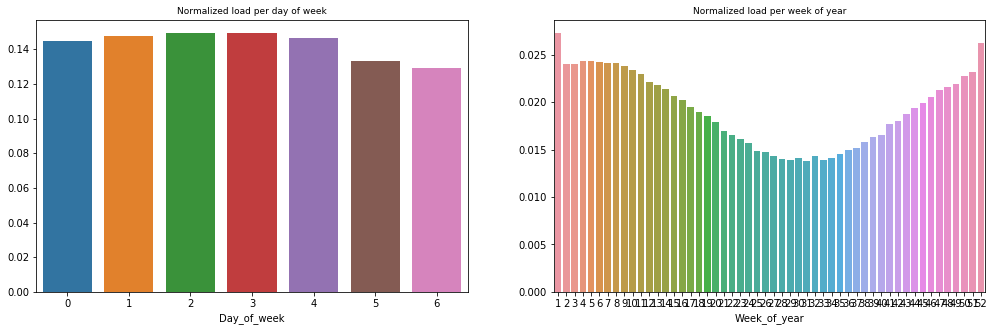

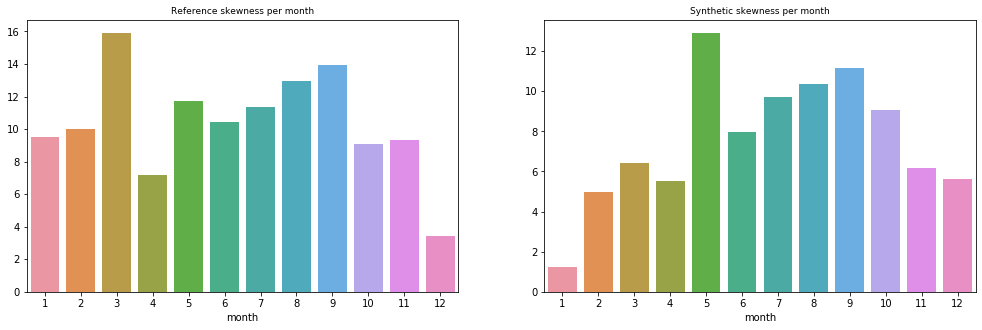

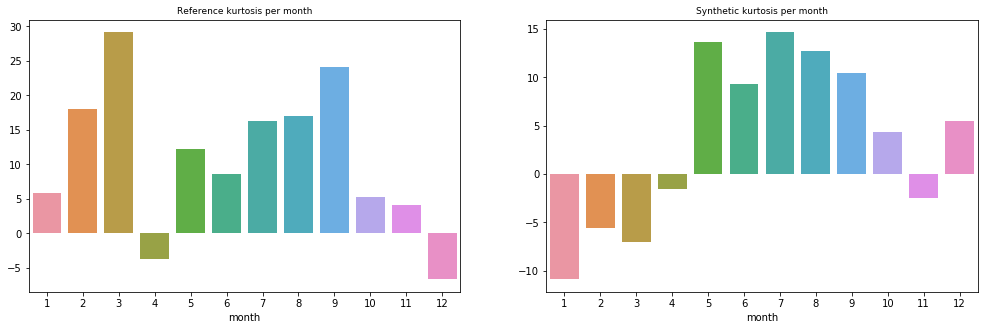

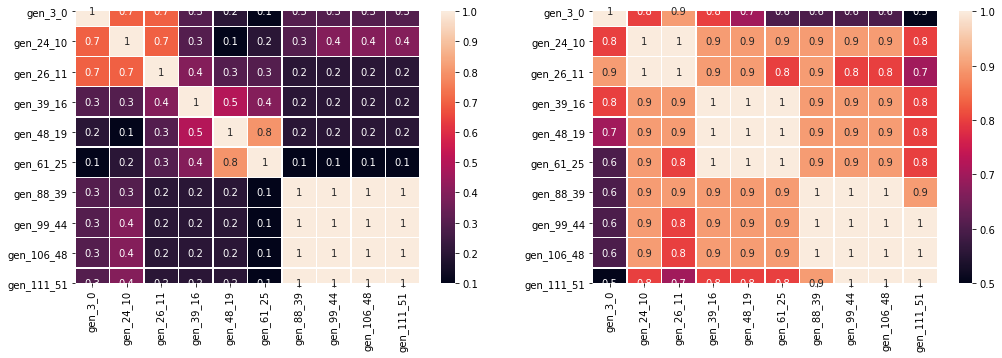

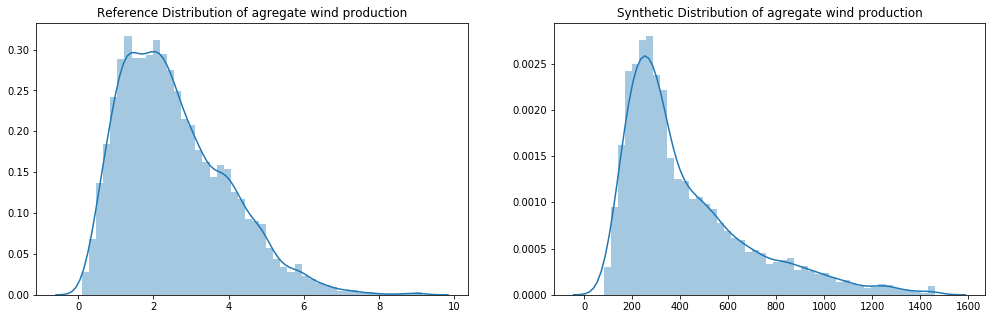

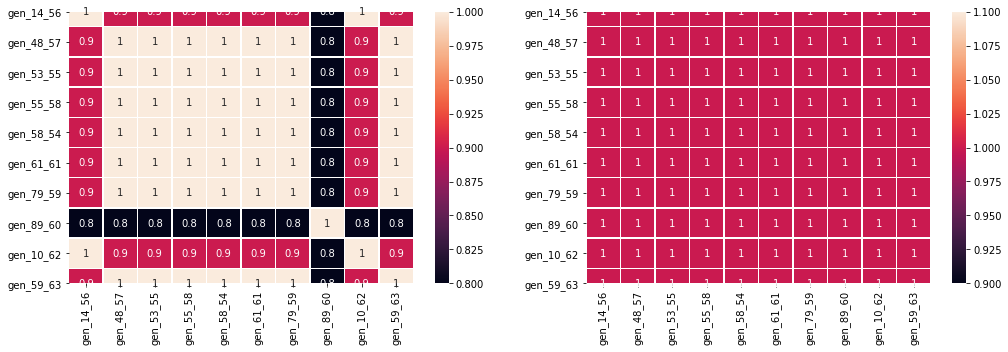

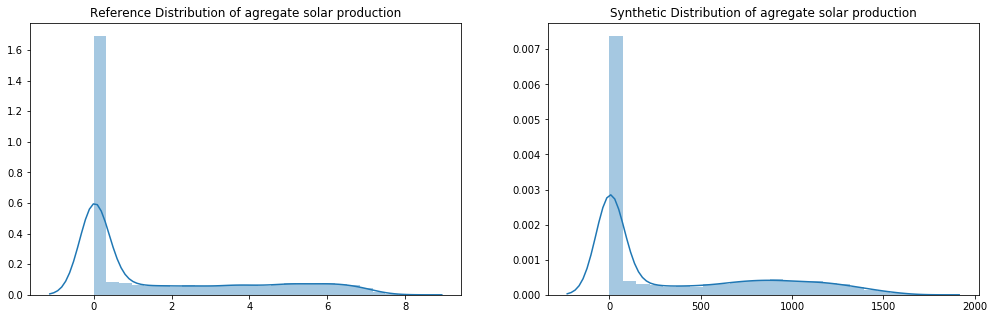

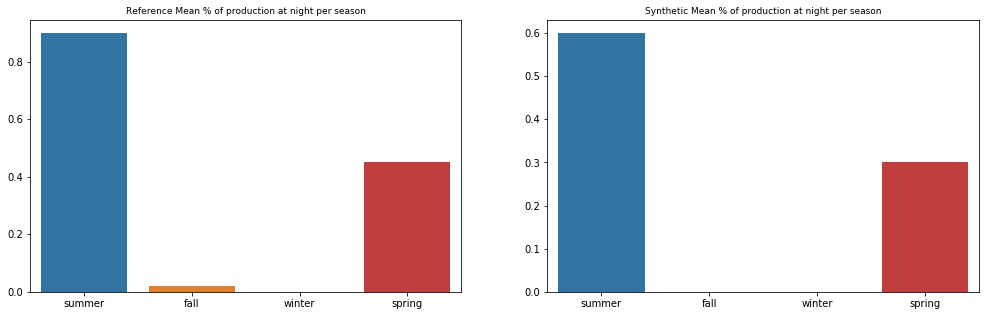

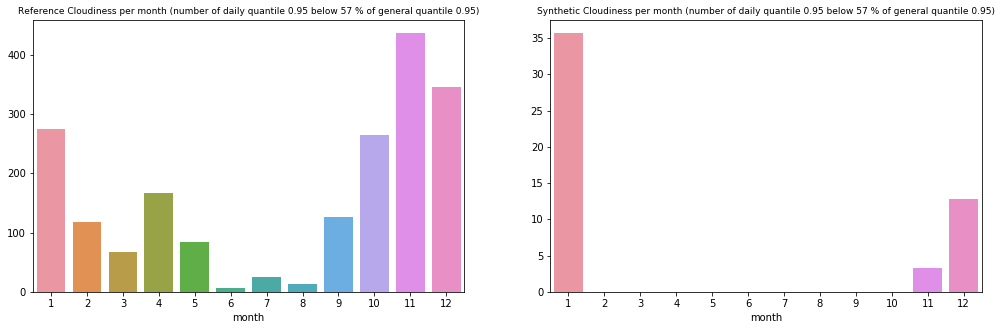

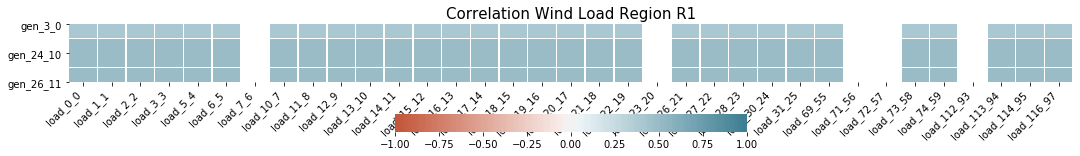

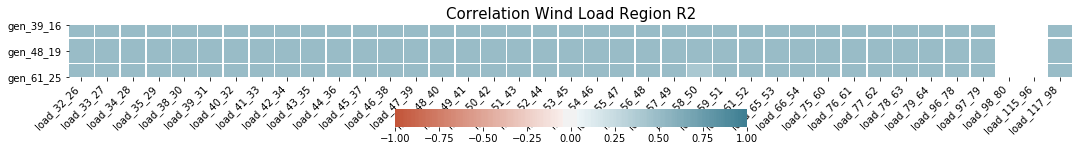

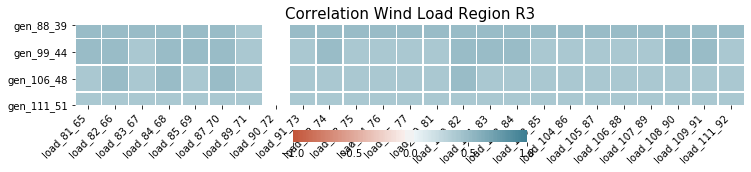

In [11]:
wind_solar_only = True
if not os.path.exists(KPI_INPUT_FOLDER):
    os.mkdir(KPI_INPUT_FOLDER)
kpis.main(KPI_INPUT_FOLDER, INPUT_FOLDER, OUTPUT_FOLDER, IMAGES_FOLDER, year, CASE, n_scenarios, wind_solar_only, params)

## Create Pypsa net

To install PyPSA correctly <br>
`pip3 install -U git+http://github.com/PyPSA/PyPSA.git@8d527e25fa9876cac66957448f449a1c901901d2`

You also need to install the solver that pypsa is calling. For instance cbc solver. On Fedora do `dnf install coin-or-Cbc.x86_64`

In [12]:
import numpy as np
import pypsa

net = pypsa.Network()

#### Add Bar

In [13]:
# Add one bus
net.add('Bus', 'node')

#### Add generators

In [14]:
for i in range(len(env118_withoutchron.name_gen)):
    net.add(class_name = 'Generator',
             name = env118_withoutchron.name_gen[i],
             bus = 'node',
             p_nom = env118_withoutchron.gen_pmax[i],
             p_nom_extendable = False,
             p_nom_min = 0,
             p_nom_max = 1,
             carrier = env118_withoutchron.gen_type[i],
             marginal_cost = env118_withoutchron.gen_cost_per_MW[i],
             committable = env118_withoutchron.gen_redispatchable[i],
             ramp_limit_up = 0.6 * env118_withoutchron.gen_max_ramp_up[i] / env118_withoutchron.gen_pmax[i],
             ramp_limit_down = 0.6 * env118_withoutchron.gen_max_ramp_down[i] / env118_withoutchron.gen_pmax[i],  
            )

In [15]:
# Keep copy of original grid
original_gen_pypsa = net.generators.copy()

In [16]:
net.generators.carrier.unique()

array(['wind', 'thermal', 'nuclear', 'hydro', 'solar'], dtype=object)

#### Remove wind and solar

In [17]:
renew_fltr = net.generators.carrier.isin(['wind', 'solar'])
net.generators.drop(net.generators.loc[renew_fltr].index, axis=0, inplace=True)

In [18]:
net.generators.carrier.unique()

array(['thermal', 'nuclear', 'hydro'], dtype=object)

#### Modify marginal costs (hydro > nuclear)

In [19]:
# Check marginal costs
net.generators.groupby('carrier').min()['marginal_cost']

carrier
hydro       8.0
nuclear     3.0
thermal    10.0
Name: marginal_cost, dtype: float64

In [20]:
# Exchange marginal costs
hydro_fltr = net.generators.carrier.isin(['hydro'])
nuclear_fltr = net.generators.carrier.isin(['nuclear'])

net.generators.loc[hydro_fltr, 'marginal_cost'] = 8
net.generators.loc[nuclear_fltr, 'marginal_cost'] = 3

In [21]:
# Check marginal costs
net.generators.groupby('carrier').min()['marginal_cost']

carrier
hydro       8.0
nuclear     3.0
thermal    10.0
Name: marginal_cost, dtype: float64

#### Add loads

In [22]:
net.add('Load',
        name = 'agg_load',
        bus = 'node',
        )

In [23]:
# renew_fltr = net.generators.carrier.isin(['wind', 'solar'])
# net.generators.loc[renew_fltr, 'ramp_limit_up'] = np.nan
# net.generators.loc[renew_fltr, 'ramp_limit_down'] = np.nan

## II B) Run a unit commitment model

we will use pypsa. To avoid messing with the names, and make sure to have data in the proper shape, it is better, I think, to create the pypsa network directly from the grid2op environment.

For more information on unit commitment see https://pypsa.org/examples/unit-commitment.html for example.

### Create hydro limits

In [24]:
dateparse = lambda x: pd.datetime.strptime(x, '%d/%m/%Y %H:%M')
hydro_pattern_path = os.path.join(INPUT_FOLDER, 'patterns', 'hydro.csv')
hydro_pattern = pd.read_csv(hydro_pattern_path, usecols=[0, 2, 3], parse_dates=[0], date_parser=dateparse)
hydro_pattern.set_index(hydro_pattern.columns[0], inplace=True)
hydro_pattern.head(3)

,p_min_u,p_max_u
Unnamed: 0,,
2016-01-01 00:00:00,0.190516,0.794653
2016-01-01 00:05:00,0.190516,0.794653
2016-01-01 00:10:00,0.190516,0.794653


In [25]:
hydro_names = net.generators[net.generators.carrier == 'hydro'].index.tolist()
hydro_names

['gen_11_4', 'gen_17_6', 'gen_53_20', 'gen_58_23']

In [26]:
max_hydro_pu = hydro_pattern[['p_max_u'] * len(hydro_names)]
max_hydro_pu.columns = hydro_names
max_hydro_pu.reset_index(drop=True, inplace=True)
max_hydro_pu.head(2)

,gen_11_4,gen_17_6,gen_53_20,gen_58_23
0,0.794653,0.794653,0.794653,0.794653
1,0.794653,0.794653,0.794653,0.794653


In [27]:
min_hydro_pu = hydro_pattern[['p_min_u'] * len(hydro_names)]
min_hydro_pu.columns = hydro_names
min_hydro_pu.reset_index(drop=True, inplace=True)
min_hydro_pu.head(2)

,gen_11_4,gen_17_6,gen_53_20,gen_58_23
0,0.190516,0.190516,0.190516,0.190516
1,0.190516,0.190516,0.190516,0.190516


### Run opf

In [28]:
params = {'snapshots': [],
          'step_opf_min': 5,
          'mode_opf': 'day',
          'reactive_comp': 1.025,
}

In [29]:
losses_pct = 3.0

# The run is by scenario
for subpath in os.listdir(chronics_path_gen):
    # Load consumption and prod
    this_path = os.path.join(chronics_path_gen, subpath)
    load_p = pd.read_csv(os.path.join(this_path, 'load_p.csv.bz2'), sep = ';', index_col = 0)
    prod_p = pd.read_csv(os.path.join(this_path, 'prod_p.csv.bz2'), sep = ';', index_col = 0)
    
    # Match hydro indices with load_p (same lenght of dataframes)
    max_hydro_pu = max_hydro_pu.loc[:load_p.shape[0]-1]
    min_hydro_pu = min_hydro_pu.loc[:load_p.shape[0]-1]

    
    # Prepare gen constraints for EDispatch module
    hydro_constraints = {'p_max_pu': max_hydro_pu, 'p_min_pu': min_hydro_pu}
    
    # Retrieve wind and solar from prod_p (Balthazar's generator)
    prod_p_wind = prod_p[[el for i, el in enumerate(env118_withoutchron.name_gen) if env118_withoutchron.gen_type[i] in ["wind"]]]
    prod_p_solar = prod_p[[el for i, el in enumerate(env118_withoutchron.name_gen) if env118_withoutchron.gen_type[i] in ["solar"]]]
    
    total_renew = pd.concat([prod_p_wind, prod_p_solar], axis=1).sum(axis=1)
    
    # Compensate the reactive part in loads
    load_ = load_p.copy() * (1 + losses_pct/100)
    load_ = load_.sum(axis=1)
    
    # Demand for OPF (total - renewable)
    agg_load_without_renew = (load_ - total_renew).to_frame()
    agg_load_without_renew.columns = ['agg_load']
    
    # Run Economic Disptach using submodule EDisptach_L2RPN_2020
    # **  **  **  **  **  **  **  **  **  **  **  **  **  **
    opf_dispatch = run_economic_dispatch.main_run_disptach(net, 
                                     agg_load_without_renew,
                                     params=params,
                                     gen_constraints=hydro_constraints,
                                     ramp_mode=run_economic_dispatch.RampMode.easy # available modes are easy, medium, hard (default)
                                    )

Preprocessing PyPSA grid..

--> OPF single formulation by: day - Analyzing day # 1


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 7.28s
INFO:pypsa.linopf:Solve linear problem using Cbc solver


** OPF failed to find a solution **


SystemExit: 

In [ ]:
# Concatenate renewable dispatch
full_opf_dispatch = pd.concat([opf_dispatch, prod_p_wind, prod_p_solar], axis=1)

# Keep same order as grid2op
full_opf_dispatch = full_opf_dispatch[env118_withoutchron.name_gen].round(2)

In [ ]:
full_opf_dispatch[hydro_names].plot(figsize=(10,4), title='Hydro Dispatch for 1 week')

In [ ]:
# Rewrite values into chronics
scenario = 'Scenario_0' # Careful: this cell was previously coded so that the last computed scenario is written. Better would be to move it in the for loop above
outputPath = os.path.join(OUTPUT_FOLDER, str(year), scenario)
full_opf_dispatch[env118_withoutchron.name_gen].to_csv(os.path.join(outputPath, "prod_p.csv.bz2"), sep=';', index=False)

In [ ]:
# Validate whether they have same order
np.all(full_opf_dispatch.columns == env118_withoutchron.name_gen)

### Compute some KPIs for dispatch
As I never had a dispatch output file, I didn't have a precise output format for the dispatch to be taken into account by the KPI module.So I chose to take the format of the only example i had: chronics exported by a previous script of Camilo with month by month dispatch chronics. 
- Download these files to have a format example on Nextcloud: https://nextcloud.artelys.com/nextcloud/s/tFirA3TRXrHeFwC
- Careful, this example is for year 2007
- We should agree on an output format from dispatch. Maybe you could put it on Nextcloud as an example for me

#### You have to set "eco2mix" as comparison in KPI_INPUT_FOLDER/paramsKPI.json
**Images were not designed to be plot on a notebook but to be saved as png or zoomable in IMAGES_FOLDER**. In particular, yearly productions and energy mix are better to watch in their written files

In [ ]:
%%capture

wind_solar_only = False
if not os.path.exists(KPI_INPUT_FOLDER):
    os.mkdir(KPI_INPUT_FOLDER)
kpis.main(KPI_INPUT_FOLDER, INPUT_FOLDER, OUTPUT_FOLDER, IMAGES_FOLDER, year, CASE, n_scenarios, wind_solar_only, params)

# III Create an environment with the chronics this time

This is to test the environment can be used by grid2op. This is what the "case118_l2rpn" will look like for the competitions.

**NB** The "Balthazar code" is fully compatible with the "GridStateFromFileWithForecasts". So it is useful to use this class to load back the data. If the data generation process does not provide the same utilities, it is not a problem to write another class, like "GridStateFromFileWithForecasts" that can read its format.

### Correct the bug in element 7_4_173

In [ ]:
# Chose generated scenario
scenario = 'Scenario_0'

In [ ]:
# line = pd.DataFrame(columns=env118_withoutchron.name_line.tolist())
# line.to_csv('/Users/camiloromero/Rte/EDispatch_L2RPN2020/lines_names.txt', sep=';', index=False)

In [ ]:
scenario_path = os.path.join(OUTPUT_FOLDER, str(year), scenario)
hazard = pd.read_csv(os.path.join(scenario_path, 'hazards.csv.bz2'), sep=';')
chronics_line_names = hazard.columns.tolist()

lines_names = {}
for g, c in zip(env118_withoutchron.name_line, chronics_line_names):
    lines_names[c] = g
    
names_chronics_to_backend = {}
names_chronics_to_backend['lines'] = lines_names

** I can't run from the following cell: can't make the dispatch run on my machine and don't data in the right format**

In [ ]:
from grid2op.ChronicsHandler import Multifolder, GridStateFromFileWithForecasts
from grid2op.Parameters import Parameters
# don't disconnect powerline on overflow, the thermal limit are not set for now, it would not make sens
param = Parameters()
param.init_from_dict({"NO_OVERFLOW_DISCONNECTION": True})

#chronics_path_gen = os.path.join(chronics_path, "chronics")
chronics_path_gen = None

env = grid2op.make("blank",  # to generate a blank environment
                   grid_path=os.path.join(path_grid, "L2RPN_2020_case118_redesigned.json"), # assign it the 118 grid
                   chronics_class=Multifolder, # tell it to change nothing (not the most usable environment...)
                   data_feeding_kwargs= {"path": chronics_path_gen, "gridvalueClass": GridStateFromFileWithForecasts},
                   param=param,
                   names_chronics_to_backend = names_chronics_to_backend,
                  )

And now we can test that we can use a Runner, store the results, and plot the flows on the powerline for example

# IV Validate the generation process

For that we use a runner, that will compute the powerflows with a "do nothing" agent, and we prevent it to disconnect any power line, even if they are on overflow.

In [ ]:
from grid2op.Runner import Runner
path_data_saved = chronics_path+"_computed"
runner = Runner(**env.get_params_for_runner())

# here you might need to change "nb_episode" if you generated more than one scenario
# this might really take some times... 4 mins per scenario per week [on one core]
res = runner.run(nb_episode=nb_episode, path_save=path_data_saved, pbar=True)

Then we can study the results, for example by loading the chronics, extracting prod p, load p etc.

In [ ]:
from grid2op.Utils import ActionSpace, ObservationSpace
import numpy as np
from tqdm.notebook import tqdm

path_data_saved_ep0 = os.path.join(path_data_saved, "0")
action_space = ActionSpace.from_dict(os.path.join(path_data_saved, "dict_action_space.json"))
env_modif_space = ActionSpace.from_dict(os.path.join(path_data_saved, "dict_env_modification_space.json"))
observation_space = ObservationSpace.from_dict(os.path.join(path_data_saved, "dict_observation_space.json"))
observations_npy = np.load(os.path.join(path_data_saved_ep0, "observations.npy"))
li_observations = []
for i in range(observations_npy.shape[0]):
    tmp = observation_space.from_vect(observations_npy[i,:])
    li_observations.append(tmp)

In [ ]:
flows_a = np.array([obs.a_or for obs in li_observations])
loads_p = np.array([obs.load_p for obs in li_observations])
prods_p = np.array([obs.prod_p for obs in li_observations])

display distribution of flows over scenarios

In [ ]:
import matplotlib.pyplot as plt
flow_a_vector=np.concatenate(flows_a, axis=None)
plt.hist(flow_a_vector,bins=200)

Computes the KPI you want with that...

In [ ]:
# TODO

Go back to **II)** if results are not satisfying.

# V Export the final results

First, regenerate a lot more data, then save then

In [ ]:
# TODO generate more data with the same distribution as the one that has been validated

In [ ]:
# TODO export them to be usable in a friendly manner